## Quitting Predictor Classifier v2

### Author: Angus Ferrell

### updated: 16 Aug 2023

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import statistics as stat
import random
import glob
import os
import re
import dabl

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, recall_score, precision_score,f1_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.cluster import KMeans
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import BSpline
import category_encoders as ce
import shap
%matplotlib inline

# Load debugger, if required
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

#set random_state
random_state=42


#data = pd.read_csv('updated_quitting_predictor_data3.csv')
#data = pd.read_csv('quitting_data_Aug2.csv')
data = pd.read_csv('quitting_data_Aug3.csv')
print(data.shape)

(185040, 370)


In [2]:
# Fill NaN values with the specified default values
data.fillna({
    'title_1': '',
    'company_1':'',
    'title_2': '',
    'company_2':'',
    'level':'',
    'education level':'',
    'total_exp': 0,
    'Quitter': 0,
    'time_duration_1': data['time_duration_1'].mean(),
    'time_duration_2': data['time_duration_2'].mean(),
    'Word_Count': 0,
    'peak': 0,
    'bins': 0,
    'company_work_dur_check': 0,
    'title_work_dur_check': 0,
    'custom_url': 0,
    'avg_salary':0,
    'norm_salary':0,
    'job_desc_application':0,
    'job_desc_data':0,
    'job_desc_design':0,
    'job_desc_development':0,
    'job_desc_project':0,
    'job_desc_service':0,
    'job_desc_software':0,
    'job_desc_system':0,
    'job_desc_team':0,
    'job_desc_using':0,
    'summary_application':0,
    'summary_data':0,
    'summary_development':0,
    'summary_experience':0,
    'summary_software':0,
    'summary_system':0,
    'summary_team':0,
    'summary_technology':0,
    'summary_web':0,
    'summary_year':0,
    'skills_agile_methodology':0,
    'skills_cs':0,
    'skills_html':0,
    'skills_java':0,
    'skills_javascript':0,
    'skills_linux':0,
    'skills_mysql':0,
    'skills_python':0,
    'skills_software_development':0,
    'skills_sql':0,
    'summary_is_null':0,
    'skills_is_null':0
    }, inplace=True)


#data.drop('Unnamed: 0',inplace=True, axis=1)

### Dabl models

**Dabl provides several useful methods for cleaning data, conducting exploratory data analysis, and building simple and more advanced ML classifiers. Only run these cells if you want to try them out**

In [ ]:
types = dabl.detect_types(data)
print(types)

In [ ]:
df = dabl.clean(data)
print(len(df.columns))

In [ ]:
for i in data.columns:
    print(i)

In [ ]:
dabl.plot(data, target_col="Quitter")

**Simple Classifier Model**

In [ ]:
columns = ['title_1', 'company_1','title_2', 'company_2', "level", "total_exp", "Quitter", "time_duration_1", 'Region', 'Word_Count',
           'peak','bins','company_work_dur_check','title_work_dur_check',"custom_url",'education level','norm_salary']

#df = data[columns]
df = data

ec = dabl.SimpleClassifier(random_state=0).fit(df, target_col='Quitter') 

In [ ]:
dabl.explain(ec,target_col='Quitter')

**Enhanced Classifier Model**

In [ ]:
ac = dabl.AnyClassifier().fit(df, target_col='Quitter') 


In [ ]:
dabl.explain(ac,target_col='Quitter')



## CatBoost Model

In [3]:
selected_columns = []

# Iterate through the column names of the DataFrame
for column_name in data.columns:
    # Check if the column name starts with 'work duration'
    if column_name.startswith('work duration'):
        # Add the column name to the list with quotations
        selected_columns.append(f'{column_name}')
        
#selected_columns        

In [4]:
columns = ['title_1','company_1','title_2','company_2','education level','level','Region','bins',
           'company_work_dur_check','title_work_dur_check','Word_Count','total_exp','custom_url',
           'time_duration_1','time_duration_2','Quitter','peak','norm_salary','Seeking','job_desc_application',
            'job_desc_data', 'job_desc_design', 'job_desc_development','job_desc_project','job_desc_service',
            'job_desc_software','job_desc_system','job_desc_team','job_desc_using','summary_application',
            'summary_data','summary_development','summary_experience','summary_software','summary_system',
            'summary_team','summary_technology', 'summary_web','summary_year','skills_agile_methodology',
            'skills_cs','skills_html','skills_java', 'skills_javascript','skills_linux','skills_mysql',
             'skills_python','skills_software_development','skills_sql','summary_is_null','skills_is_null']

newcolumns = columns + selected_columns
df = data[newcolumns]


### When reducing number of features in the future, begin with the features below ###

test_col = ['title_1','company_1','title_2','company_2','education level','level','Region','total_exp',
            'work duration in years__sum_values','time_duration_2','skills_is_null','time_duration_1',
            'norm_salary','title_work_dur_check', 'Word_Count','custom_url','Quitter']
          
#df = data[test_col]

In [5]:
df['peak'].astype(int)
df['bins'].astype(int)
df['total_exp'].astype(int)
df['Word_Count'].astype(int)
df['custom_url'].astype(int)
df['Seeking'].astype(int)
df['time_duration_1'].astype(float)
df['time_duration_2'].astype(float)
df['company_work_dur_check'].astype(float)
df['title_work_dur_check'].astype(float)
df['norm_salary'].astype(float)
df['title_1'].astype(str)
df['company_1'].astype(str)
df['title_2'].astype(str)
df['company_2'].astype(str)
df['level'].astype(str)
df['Region'].astype(str)
df['education level'].astype(str)
df['job_desc_application'] = df['job_desc_application'].astype(int)
df['job_desc_data'] = df['job_desc_data'].astype(int)
df['job_desc_design'] = df['job_desc_design'].astype(int)
df['job_desc_development'] = df['job_desc_development'].astype(int)
df['job_desc_project'] = df['job_desc_project'].astype(int)
df['job_desc_service'] = df['job_desc_service'].astype(int)
df['job_desc_software'] = df['job_desc_software'].astype(int)
df['job_desc_system'] = df['job_desc_system'].astype(int)
df['job_desc_team'] = df['job_desc_team'].astype(int)
df['job_desc_using'] = df['job_desc_using'].astype(int)
df['summary_application'] = df['summary_application'].astype(int)
df['summary_data'] = df['summary_data'].astype(int)
df['summary_development'] = df['summary_development'].astype(int)
df['summary_experience'] = df['summary_experience'].astype(int)
df['summary_software'] = df['summary_software'].astype(int)
df['summary_system'] = df['summary_system'].astype(int)
df['summary_team'] = df['summary_team'].astype(int)
df['summary_technology'] = df['summary_technology'].astype(int)
df['summary_web'] = df['summary_web'].astype(int)
df['summary_year'] = df['summary_year'].astype(int)
df['skills_agile_methodology'] = df['skills_agile_methodology'].astype(int)
df['skills_cs'] = df['skills_cs'].astype(int)
df['skills_html'] = df['skills_html'].astype(int)
df['skills_java'] = df['skills_java'].astype(int)
df['skills_javascript'] = df['skills_javascript'].astype(int)
df['skills_linux'] = df['skills_linux'].astype(int)
df['skills_mysql'] = df['skills_mysql'].astype(int)
df['skills_python'] = df['skills_python'].astype(int)
df['skills_software_development'] = df['skills_software_development'].astype(int)
df['skills_sql'] = df['skills_sql'].astype(int)
df['Word_Count'] = df['Word_Count'].astype(int)
df['summary_is_null'] = df['summary_is_null'].astype(int)
df['skills_is_null'] = df['skills_is_null'].astype(int)

In [6]:
### Train/Test split to create X_test, X_train, y_test, y_train
# use undersampler if wanting to undersample majority class

X = df.drop('Quitter', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, df['Quitter'], test_size=0.25, stratify=df['Quitter'],
                                                    random_state=2)

from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class (target 0)
#rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
#X_train, y_train = rus.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

categorical_features_indices = [0,1,2,3,4,5,6]
y_train = pd.to_numeric(y_train).astype('int32')
y_test = pd.to_numeric(y_test).astype('int32')

(138780, 289)
(138780,)
(46260, 289)
(46260,)


In [7]:
categorical_features_indices

[0, 1, 2, 3, 4, 5, 6]

In [8]:
# this function aims to streamline the process of fitting, evaluating, and reporting results for a classification 
# model. It automatically searches for the best hyperparameters, assesses the model's performance, and 
#provides various visualizations and metrics to aid in understanding the model's behavior.

def fit_classification(model, X_train,y_train, X_test, y_test,
                          cv_parameters = {},
                          model_name = None,
                          random_state = 42,
                          output_to_file = True,
                          print_to_screen = True):
    
    np.random.seed(random_state)

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train,cat_features=categorical_features_indices)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No TS', 'TS'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    #tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    #if print_to_screen:
        #print("")
        #print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
 
    return out

In [9]:
def test_model(best_model, X_train,y_train, X_test, y_test, print_to_screen = True):
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['NonQuitter', 'Quitter'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)

        

In [ ]:
### Hyper-parameter tuning ###

CatBoost = CatBoostClassifier(iterations=10,custom_loss='Recall',eval_metric='Recall',random_seed=42)

cv_parameters = {
    'learning_rate': [0.01,0.1,0.3],
    'depth': [4,10,12,16],
    'l2_leaf_reg':[4, 10,12,16],
    'random_strength':[0,10],
    'class_weights': [[1,1],[1,1.5]]}

cb = fit_classification(CatBoost, X_train,y_train, X_test, y_test, cv_parameters,
                         'CatBoost', output_to_file = False)

0:	learn: 0.2501395	test: 0.2510460	best: 0.2510460 (0)	total: 16.4s	remaining: 2h 16m 27s
1:	learn: 0.2418410	test: 0.2405858	best: 0.2510460 (0)	total: 32.2s	remaining: 2h 13m 46s
2:	learn: 0.2373780	test: 0.2228033	best: 0.2510460 (0)	total: 47.8s	remaining: 2h 12m 3s
3:	learn: 0.2425384	test: 0.2276151	best: 0.2510460 (0)	total: 1m 3s	remaining: 2h 10m 18s
4:	learn: 0.2598326	test: 0.2493724	best: 0.2510460 (0)	total: 1m 18s	remaining: 2h 9m 47s
5:	learn: 0.2740586	test: 0.2623431	best: 0.2623431 (5)	total: 1m 33s	remaining: 2h 8m 37s
6:	learn: 0.2677824	test: 0.2481172	best: 0.2623431 (5)	total: 1m 48s	remaining: 2h 7m 48s
7:	learn: 0.2745467	test: 0.2451883	best: 0.2623431 (5)	total: 2m 4s	remaining: 2h 7m 25s
8:	learn: 0.2824965	test: 0.2424686	best: 0.2623431 (5)	total: 2m 21s	remaining: 2h 8m 41s
9:	learn: 0.2905160	test: 0.2500000	best: 0.2623431 (5)	total: 2m 38s	remaining: 2h 9m 46s
10:	learn: 0.2981172	test: 0.2493724	best: 0.2623431 (5)	total: 2m 54s	remaining: 2h 9m 1s
1

89:	learn: 0.6811715	test: 0.3401674	best: 0.3414226 (87)	total: 28m 36s	remaining: 2h 10m 17s
90:	learn: 0.6850070	test: 0.3391213	best: 0.3414226 (87)	total: 28m 51s	remaining: 2h 9m 41s
91:	learn: 0.6859833	test: 0.3405858	best: 0.3414226 (87)	total: 29m 6s	remaining: 2h 9m 4s
92:	learn: 0.6903068	test: 0.3405858	best: 0.3414226 (87)	total: 29m 21s	remaining: 2h 8m 27s
93:	learn: 0.6940725	test: 0.3412134	best: 0.3414226 (87)	total: 29m 35s	remaining: 2h 7m 50s
94:	learn: 0.6949093	test: 0.3420502	best: 0.3420502 (94)	total: 29m 51s	remaining: 2h 7m 15s
95:	learn: 0.6971409	test: 0.3435146	best: 0.3435146 (95)	total: 30m 5s	remaining: 2h 6m 39s
96:	learn: 0.7010460	test: 0.3437238	best: 0.3437238 (96)	total: 30m 20s	remaining: 2h 6m 5s
97:	learn: 0.7051604	test: 0.3420502	best: 0.3437238 (96)	total: 30m 35s	remaining: 2h 5m 30s
98:	learn: 0.7105300	test: 0.3420502	best: 0.3437238 (96)	total: 30m 51s	remaining: 2h 4m 58s
99:	learn: 0.7154812	test: 0.3439331	best: 0.3439331 (99)	total

175:	learn: 0.9345886	test: 0.3485356	best: 0.3518828 (163)	total: 1h 9s	remaining: 1h 50m 44s
176:	learn: 0.9354951	test: 0.3472803	best: 0.3518828 (163)	total: 1h 25s	remaining: 1h 50m 15s
177:	learn: 0.9359833	test: 0.3485356	best: 0.3518828 (163)	total: 1h 40s	remaining: 1h 49m 44s
178:	learn: 0.9370990	test: 0.3476987	best: 0.3518828 (163)	total: 1h 55s	remaining: 1h 49m 15s
179:	learn: 0.9387727	test: 0.3489540	best: 0.3518828 (163)	total: 1h 1m 11s	remaining: 1h 48m 46s
180:	learn: 0.9403766	test: 0.3487448	best: 0.3518828 (163)	total: 1h 1m 26s	remaining: 1h 48m 16s
181:	learn: 0.9412134	test: 0.3483264	best: 0.3518828 (163)	total: 1h 1m 41s	remaining: 1h 47m 47s
182:	learn: 0.9422594	test: 0.3474895	best: 0.3518828 (163)	total: 1h 1m 56s	remaining: 1h 47m 18s
183:	learn: 0.9436541	test: 0.3489540	best: 0.3518828 (163)	total: 1h 2m 11s	remaining: 1h 46m 49s
184:	learn: 0.9442817	test: 0.3495816	best: 0.3518828 (163)	total: 1h 2m 27s	remaining: 1h 46m 20s
185:	learn: 0.9460251	t

258:	learn: 0.9886332	test: 0.3573222	best: 0.3589958 (250)	total: 1h 57m 26s	remaining: 1h 49m 16s
259:	learn: 0.9892608	test: 0.3571130	best: 0.3589958 (250)	total: 1h 57m 43s	remaining: 1h 48m 39s
260:	learn: 0.9892608	test: 0.3556485	best: 0.3589958 (250)	total: 1h 58m	remaining: 1h 48m 3s
261:	learn: 0.9894700	test: 0.3560669	best: 0.3589958 (250)	total: 1h 58m 15s	remaining: 1h 47m 25s
262:	learn: 0.9896095	test: 0.3564854	best: 0.3589958 (250)	total: 1h 58m 32s	remaining: 1h 46m 48s
263:	learn: 0.9896792	test: 0.3558577	best: 0.3589958 (250)	total: 1h 58m 48s	remaining: 1h 46m 12s
264:	learn: 0.9895397	test: 0.3571130	best: 0.3589958 (250)	total: 1h 59m 4s	remaining: 1h 45m 36s
265:	learn: 0.9895397	test: 0.3592050	best: 0.3592050 (265)	total: 1h 59m 21s	remaining: 1h 45m
266:	learn: 0.9901674	test: 0.3598326	best: 0.3598326 (266)	total: 1h 59m 37s	remaining: 1h 44m 23s
267:	learn: 0.9906555	test: 0.3594142	best: 0.3598326 (266)	total: 1h 59m 52s	remaining: 1h 43m 46s
268:	learn

341:	learn: 0.9983264	test: 0.3640167	best: 0.3667364 (298)	total: 2h 19m 56s	remaining: 1h 4m 38s
342:	learn: 0.9982566	test: 0.3644351	best: 0.3667364 (298)	total: 2h 20m 12s	remaining: 1h 4m 10s
343:	learn: 0.9982566	test: 0.3644351	best: 0.3667364 (298)	total: 2h 20m 28s	remaining: 1h 3m 42s
344:	learn: 0.9983264	test: 0.3654812	best: 0.3667364 (298)	total: 2h 20m 45s	remaining: 1h 3m 14s
345:	learn: 0.9985356	test: 0.3638075	best: 0.3667364 (298)	total: 2h 21m 2s	remaining: 1h 2m 46s
346:	learn: 0.9985356	test: 0.3640167	best: 0.3667364 (298)	total: 2h 21m 19s	remaining: 1h 2m 18s
347:	learn: 0.9985356	test: 0.3644351	best: 0.3667364 (298)	total: 2h 21m 37s	remaining: 1h 1m 51s
348:	learn: 0.9985356	test: 0.3640167	best: 0.3667364 (298)	total: 2h 21m 55s	remaining: 1h 1m 24s
349:	learn: 0.9986053	test: 0.3633891	best: 0.3667364 (298)	total: 2h 22m 11s	remaining: 1h 56s
350:	learn: 0.9986750	test: 0.3629707	best: 0.3667364 (298)	total: 2h 22m 28s	remaining: 1h 28s
351:	learn: 0.998

426:	learn: 0.9997211	test: 0.3661088	best: 0.3692469 (406)	total: 2h 43m 18s	remaining: 27m 55s
427:	learn: 0.9997211	test: 0.3671548	best: 0.3692469 (406)	total: 2h 43m 35s	remaining: 27m 31s
428:	learn: 0.9997211	test: 0.3667364	best: 0.3692469 (406)	total: 2h 43m 52s	remaining: 27m 7s
429:	learn: 0.9997211	test: 0.3658996	best: 0.3692469 (406)	total: 2h 44m 8s	remaining: 26m 43s
430:	learn: 0.9997211	test: 0.3665272	best: 0.3692469 (406)	total: 2h 44m 25s	remaining: 26m 19s
431:	learn: 0.9997211	test: 0.3658996	best: 0.3692469 (406)	total: 2h 44m 42s	remaining: 25m 55s
432:	learn: 0.9997211	test: 0.3656904	best: 0.3692469 (406)	total: 2h 44m 59s	remaining: 25m 31s
433:	learn: 0.9997211	test: 0.3648536	best: 0.3692469 (406)	total: 2h 45m 16s	remaining: 25m 8s
434:	learn: 0.9997211	test: 0.3646444	best: 0.3692469 (406)	total: 2h 45m 33s	remaining: 24m 44s
435:	learn: 0.9997908	test: 0.3652720	best: 0.3692469 (406)	total: 2h 45m 50s	remaining: 24m 20s
436:	learn: 0.9997908	test: 0.364

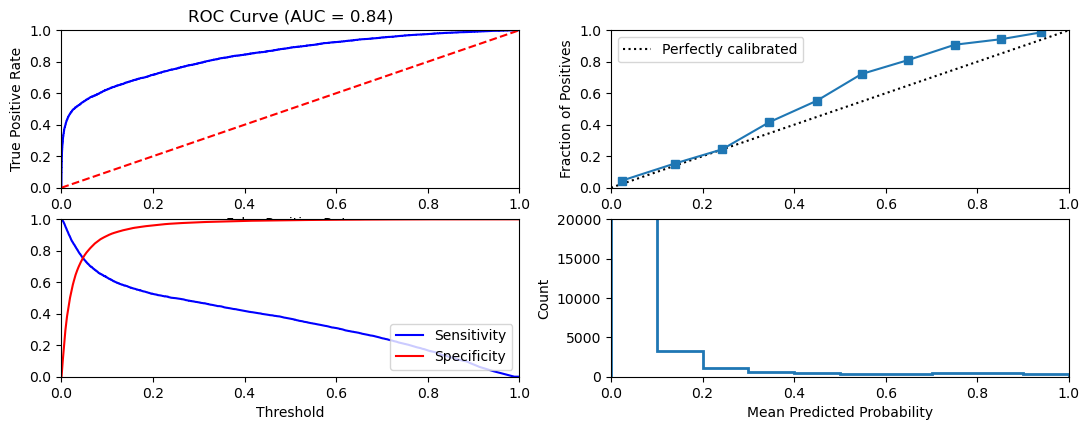

Brier score: 0.06034151471787368
Quitters predicted:  15817
percentage:  0.08547881539126675


In [10]:
### Select best hyperparameters from abouve and run with more iterations ###

CatBoost_final = CatBoostClassifier(iterations=500,random_seed=2,class_weights= [1, 1.5], custom_loss='Recall',
                              depth=16, eval_metric='Recall', l2_leaf_reg=16, learning_rate=0.1, random_strength=0)

CatBoost_final.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    )

test_model(CatBoost_final, X_train, y_train, X_test, y_test)

final_predictions = CatBoost_final.predict(X)
total = len(final_predictions)
calc = np.sum(final_predictions==1)
print('Quitters predicted: ',calc)
print('percentage: ',calc/total)

In [38]:
### write out predictions to csv ###

final_predictions = CatBoost_final.predict(X)
final_prob = CatBoost_final.predict_proba(X)
proba_df = pd.DataFrame(final_prob)
data['prediction'] = final_predictions
data['confidence'] = proba_df[[1]]
#mask = X_test.index
#test = data.loc[mask]
output = data[['profile_url','prediction','confidence']]
output.to_csv('output_Aug8.csv')



In [25]:
### use RFE for feature ranking ###

X_train_slice = X_train[:100]
y_train_slice = y_train[:100]
X_test_slice = X_test[:100]
y_test_slice = y_test[:100]

columns_to_encode=['title_1','company_1','title_2','company_2','education level','level','Region']
encoder = ce.cat_boost.CatBoostEncoder(cols=columns_to_encode)

# Apply the encoding to the DataFrame
X_train_encoded = encoder.fit_transform(X_train_slice, y_train_slice)
X_test_encoded = encoder.transform(X_test_slice, y_test_slice)

# Now, you can use RFE on the transformed data
selector = RFE(CatBoost_final, n_features_to_select=25, step=1)
selector = selector.fit(X_train_encoded, y_train_slice)
selected_feature_names = X_train_encoded.columns[selector.support_]
selected_feature_rank = X_train_encoded.columns[selector.ranking_]

# Print out the selected features
print("Selected Features:")
print(selected_feature_names)

# Print out the ranking of features
print("Feature Rankings:")
print(selected_feature_rank[:25])


0:	learn: 1.0000000	total: 18.1ms	remaining: 3.61s
1:	learn: 1.0000000	total: 35.9ms	remaining: 3.56s
2:	learn: 1.0000000	total: 53.5ms	remaining: 3.51s
3:	learn: 1.0000000	total: 55.6ms	remaining: 2.72s
4:	learn: 1.0000000	total: 58.7ms	remaining: 2.29s
5:	learn: 1.0000000	total: 67.8ms	remaining: 2.19s
6:	learn: 1.0000000	total: 73ms	remaining: 2.01s
7:	learn: 1.0000000	total: 82.8ms	remaining: 1.99s
8:	learn: 1.0000000	total: 91.7ms	remaining: 1.95s
9:	learn: 1.0000000	total: 110ms	remaining: 2.09s
10:	learn: 1.0000000	total: 144ms	remaining: 2.48s
11:	learn: 1.0000000	total: 154ms	remaining: 2.41s
12:	learn: 1.0000000	total: 160ms	remaining: 2.3s
13:	learn: 1.0000000	total: 163ms	remaining: 2.17s
14:	learn: 1.0000000	total: 199ms	remaining: 2.46s
15:	learn: 1.0000000	total: 233ms	remaining: 2.67s
16:	learn: 1.0000000	total: 238ms	remaining: 2.57s
17:	learn: 1.0000000	total: 242ms	remaining: 2.45s
18:	learn: 1.0000000	total: 244ms	remaining: 2.33s
19:	learn: 1.0000000	total: 254ms	r

165:	learn: 1.0000000	total: 2.85s	remaining: 584ms
166:	learn: 1.0000000	total: 2.87s	remaining: 567ms
167:	learn: 1.0000000	total: 2.88s	remaining: 549ms
168:	learn: 1.0000000	total: 2.89s	remaining: 531ms
169:	learn: 1.0000000	total: 2.91s	remaining: 514ms
170:	learn: 1.0000000	total: 2.93s	remaining: 498ms
171:	learn: 1.0000000	total: 2.94s	remaining: 479ms
172:	learn: 1.0000000	total: 2.95s	remaining: 460ms
173:	learn: 1.0000000	total: 2.95s	remaining: 441ms
174:	learn: 1.0000000	total: 2.97s	remaining: 425ms
175:	learn: 1.0000000	total: 2.98s	remaining: 406ms
176:	learn: 1.0000000	total: 3s	remaining: 389ms
177:	learn: 1.0000000	total: 3s	remaining: 371ms
178:	learn: 1.0000000	total: 3.02s	remaining: 355ms
179:	learn: 1.0000000	total: 3.04s	remaining: 338ms
180:	learn: 1.0000000	total: 3.04s	remaining: 320ms
181:	learn: 1.0000000	total: 3.08s	remaining: 305ms
182:	learn: 1.0000000	total: 3.09s	remaining: 287ms
183:	learn: 1.0000000	total: 3.1s	remaining: 270ms
184:	learn: 1.00000

In [ ]:
# Use shap for feature explaination ### 
X_train_slice = X_train

# Create an explainer using your trained model
explainer = shap.Explainer(CatBoost_final)
shap_values = explainer(X_train_slice)
shap.summary_plot(shap_values, X_train_slice, feature_names=X_train_slice.columns)


In [13]:
print(CatBoost_final.get_feature_importance(prettified=True)[:30])

                                           Feature Id  Importances
0                                           total_exp     9.902905
1                  work duration in years__sum_values     7.041696
2                                     time_duration_2     5.752762
3                                      skills_is_null     5.123055
4                                           company_1     4.370291
5                                     time_duration_1     4.362196
6                                              Region     3.658130
7                                title_work_dur_check     3.195659
8                                         norm_salary     2.863637
9                                             title_1     2.512074
10        work duration in years__benford_correlation     2.223742
11                                         Word_Count     2.154473
12                                         custom_url     1.780888
13  work duration in years__index_mass_quantile__q...     1.77

### Check for overfitting

In [23]:
y_train_pred = CatBoost_final.predict(X_train)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

print('Accuracy:')
print(accuracy_score(y_train, y_train_pred))

print()
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))


Accuracy:
0.9526588845654993

Confusion Matrix:
[[123836    604]
 [  5966   8374]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    124440
           1       0.93      0.58      0.72     14340

    accuracy                           0.95    138780
   macro avg       0.94      0.79      0.85    138780
weighted avg       0.95      0.95      0.95    138780



### XGBoost Model

In [ ]:
import xgboost as xgb
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# Assuming the first 7 columns need category encoding
columns_to_encode=['title_1','company_1','title_2','company_2','education level','level','Region']
encoder = ce.cat_boost.CatBoostEncoder(cols=columns_to_encode)

# Apply the encoding to the DataFrame
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test, y_test)


# Apply one-hot encoding to categorical columns
#encoder = ce.OrdinalEncoder(cols=columns_to_encode)
#encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
#X_test_encoded = encoder.transform(X_test[categorical_columns])

In [ ]:
# Convert encoded features to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate encoded categorical features with remaining features
X_train_final = pd.concat([X_train_encoded_df, X_train_remaining], axis=1)

# Similarly, do the same for X_test
X_test_encoded = encoder.transform(X_test[categorical_columns])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_test_remaining = X_test.drop(columns=categorical_columns)
X_test_final = pd.concat([X_test_encoded_df, X_test_remaining], axis=1)



In [ ]:
# Create and train the XGBoost classifier
classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # You can change the evaluation metric as needed
    random_state=42
)
classifier.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_final)

# Calculate and print accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
